## Setup - imports, time, parameters, size function

In [1]:
from invisible_cities.database import load_db

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sys import getsizeof

In [3]:
import sys

def get_size(obj, seen=None,):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [4]:
from time import time as time
t0 = time()

In [5]:
runno = '7491'

In [6]:
# Fit functions

def gauss(x, A, m, s):
    if s < 0:
        return 10000000000000000
    return A*np.exp(-(x-m)**2 / (2*s**2))

def gauss2(x, A, m, v): 
    if v <= 0:
        return 1e10
    return A*np.exp(-(x-m)**2 / (2*v))

def offset_gauss(x, A, m, v, C):
    return C + A*np.exp(-(x-m)**2 / (2*v))

def const(x, a):
    return a + 0*x

def line(x, m, b):
    return m*x + b

from scipy.optimize import curve_fit

def exp_dt(sig):
    """
    expected drift distance  as a function of sigma of the S2 signal (Zrms from kdst 2018 version)
    parameters from the ad-hoc fit
    """
    p = [-10.00667732,  52.1855012,   12.68195726,  58.66322846, -20.11819297]
    dt = p[0] * sig**4 + p[1] * sig**3 + p[2]*sig**2 + p[3]*sig + p[4]
    return dt

## HIGH STATISTICS COMBINED FILE READING

In [7]:
f = open('/Volumes/NEXT_data/IC_Data/krThesis/sliding_window_events/meshed_outputs_20201222/meshed_output_allfiles_'+runno+'.json')
histat_data = json.load(f)
f.close()

In [8]:
histat_data.keys()

dict_keys(['events_energy', 'events_prewindow_sums', 'all_Zgauss', 'all_Wgauss', 'all_Zrms', 'all_Wrms', 'events_X_sipm_subtracted', 'events_Y_sipm_subtracted', 'all_R2', 'events_postwindow_sums', 'all_sres', 'all_ssres'])

In [9]:
len(histat_data['events_energy'])

690182

In [10]:
histat_events_energy_subtracted = np.array(histat_data['events_energy']) - np.array(histat_data['events_prewindow_sums'])
histat_Zgauss = np.array(histat_data['all_Zgauss'])
histatX, histatY = np.array(histat_data['events_X_sipm_subtracted']), np.array(histat_data['events_Y_sipm_subtracted'])
histatR2 = np.array(histat_data['all_R2'])

In [11]:
import itertools as it
zlims = [100, 200, 300, 400, 510]
rlims = [50, 100, 150, 180]
nomask = np.ones(len(histat_events_energy_subtracted), dtype='bool')

def get_bin_from_xy(x, y, emap, bounds):
    lowerx, lowery = bounds[0][0], bounds[1][0]
    upperx, uppery = bounds[0][1], bounds[1][1]
    nbinsx = len(emap)
    nbinsy = len(emap[0])
    dbinx = (bounds[0][1] - bounds[0][0]) / nbinsx
    dbiny = (bounds[1][1] - bounds[1][0]) / nbinsy
    ix = min(floor((x - lowerx) / dbinx), nbinsx-1)
    iy = min(floor((y - lowery) / dbiny), nbinsy-1)
    return ix, iy

def correct_energies(emap, bounds, umask = nomask, ltmap = None, show = True, xvals = histatX, yvals = histatY, energies = histat_events_energy_subtracted, vocal = False):
    if vocal:
        print('Correcting energies...')
    ecorrs = []
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    tcorstart = time()
    masked_xvals, masked_yvals = xvals[umask & xymask], yvals[umask & xymask]
    masked_energies = energies[umask & xymask]
    ncorevents = len(masked_xvals)
    factor_default = emap[int(len(emap)/2)][int(len(emap)/2)]
    for e in range(ncorevents):
        if vocal and e % 10000 == 0:
            print(e, '/', len(xvals[umask & xymask]))
            if e > 0:
                print('Est remaining =', round((ncorevents - e)*(time() - tcorstart) / e, 1))
        x, y = masked_xvals[e], masked_yvals[e]
        ix, iy = get_bin_from_xy(x, y, emap, bounds)
        factor = emap[ix][iy]
        if factor == 0 or np.isnan(factor):
            factor = factor_default
        if ltmap is not None:
            ixlt, iylt = get_bin_from_xy(x, y, ltmap, bounds)
            lt = ltmap[ixlt][iylt]
            z = all_Zgauss[umask & xymask][e]
            ltcorr = np.exp(z / lt)
            factor /= ltcorr
        ecorr = masked_energies[e] / factor
        ecorrs.append(ecorr)
    if show:
        plt.hist(ecorrs)
        plt.show()
    return np.array(ecorrs)

def fit_res_vs_zr(energies, emap, bounds, umask = nomask, show = True, xvals = histatX, yvals = histatY, zvals = histat_Zgauss):
    res_vs_zr = {}
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    masked_xvals, masked_yvals, masked_zvals = xvals[umask & xymask], yvals[umask & xymask], zvals[umask & xymask]

    for zlim, rlim in it.product(zlims, rlims):
    
        fidmask = ((masked_xvals**2 + masked_yvals**2) < rlim**2) & (masked_zvals < zlim)
        h = plt.hist(energies[fidmask], range=(0.85, 1.15), bins = 30)

        xdata = (h[1][:-1] + h[1][1:]) / 2
        ydata = h[0]

        (A0, m0, s0) = (np.max(ydata), 1, np.std(energies[fidmask]))
        print('Attempting to fit a Gaussian with guess (A0, m0, s0) =', (A0, m0, s0))
        popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
        fitgauss = gauss(xdata, *popt)

        FWHM = 2.355 * popt[2]
        mean = popt[1]
        resolution = 100 * FWHM / mean

        res_vs_zr[zlim*1000+rlim] = resolution

        if show:
            plt.title('Z < '+str(zlim)+'; R < '+str(rlim)+'. Resolution = '+str(round(resolution, 1))+'%')
            plt.plot(xdata, fitgauss)
            plt.show()
    
    return res_vs_zr

def plot_res_vs_zr(res_vs_zr):
    for rlim in rlims:
        res_vs_z = [ res_vs_zr[1000*zlim + rlim] for zlim in zlims ]
        plt.plot(zlims, res_vs_z, 'o', label = 'rlim = '+str(rlim)+' mm')
    plt.legend()
    plt.xlabel('Z upper limit (mm)')
    plt.ylabel('Resolution (%)')
    plt.show()
    print('Best resolution = ', round(min(res_vs_zr.values()), 1), '%')
    
import h5py

def load_maps_from_file(filename, show = True):
    f = h5py.File(filename, 'r')
    e0map = np.array(f['e0']['block0_values'])
    ltmap = np.array(f['lt']['block0_values'])
    # f['mapinfo']['index'][i] tells you what is stored is stored in f['mapinfo']['values'][i]
    bounds = ((f['mapinfo']['values'][0], f['mapinfo']['values'][1]), (f['mapinfo']['values'][2], f['mapinfo']['values'][3]))
    f.close()

    if show:
        plt.imshow(e0map, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]])
        plt.colorbar()
        plt.title('E0')
        plt.show()

        plt.imshow(ltmap, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]])
        plt.colorbar()
        plt.title('LT')
        plt.clim(5000, 10000)
        plt.show()
    
    return e0map, ltmap, bounds

## Determine the range of the peak

In [12]:
noise_bound = 250
r2cut = 0.9
zmax = 510
hienergybound = 2 # Events with double the median energy are excluded as possible Kr events
r2mask = histatR2 > r2cut
zmask = (histat_Zgauss > 0) & (histat_Zgauss < zmax)
rmask = histatX**2 + histatY**2 < 180**2
r2ZRnoisemask = r2mask & (histat_events_energy_subtracted > noise_bound) & zmask & rmask
hienergymask = histat_events_energy_subtracted < hienergybound * np.percentile(histat_events_energy_subtracted[r2ZRnoisemask], 50)
r2ZRhinoisemask = r2ZRnoisemask & hienergymask


In [13]:
for i in range(100):
    lower = (100. - i) / 2
    upper = lower + i
    print(i, '% =',lower,'to', upper,'=', np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], lower), ',', np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], upper))

0 % = 50.0 to 50.0 = 9096.191746409571 , 9096.191746409571
1 % = 49.5 to 50.5 = 9083.424184964888 , 9109.705712050654
2 % = 49.0 to 51.0 = 9070.919108861626 , 9122.748722678727
3 % = 48.5 to 51.5 = 9058.294620625977 , 9136.723246378839
4 % = 48.0 to 52.0 = 9044.734689875899 , 9148.515153916394
5 % = 47.5 to 52.5 = 9031.974107446926 , 9161.435189080185
6 % = 47.0 to 53.0 = 9018.857757513211 , 9174.892942882052
7 % = 46.5 to 53.5 = 9007.088084408882 , 9188.041883685448
8 % = 46.0 to 54.0 = 8994.148449005017 , 9200.825560686164
9 % = 45.5 to 54.5 = 8979.15504234721 , 9214.011974675183
10 % = 45.0 to 55.0 = 8965.315736609662 , 9226.739052655636
11 % = 44.5 to 55.5 = 8950.805933533016 , 9239.458430836425
12 % = 44.0 to 56.0 = 8937.4050865831 , 9252.845615429245
13 % = 43.5 to 56.5 = 8924.725367679353 , 9265.68548698849
14 % = 43.0 to 57.0 = 8910.009300652018 , 9277.784178673946
15 % = 42.5 to 57.5 = 8896.488556566856 , 9290.77354646885
16 % = 42.0 to 58.0 = 8883.198328552397 , 9303.83068244

In [14]:
lft = np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 2.5)
rgt = np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 97.5)
print(round(lft,1),',', round(rgt,1))

6170.5 , 12446.3


In [15]:
histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted > lft) & (histat_events_energy_subtracted < rgt)

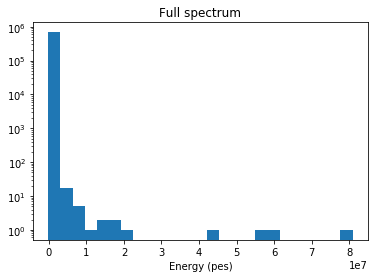

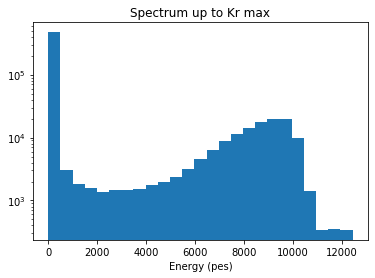

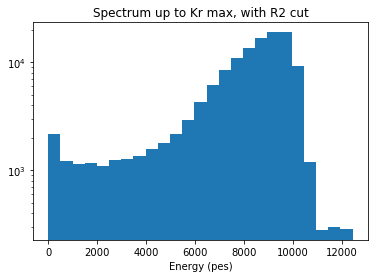

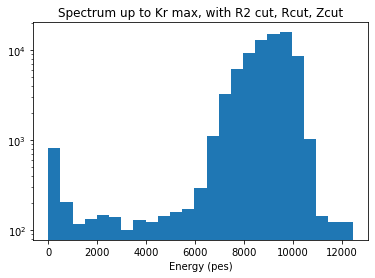

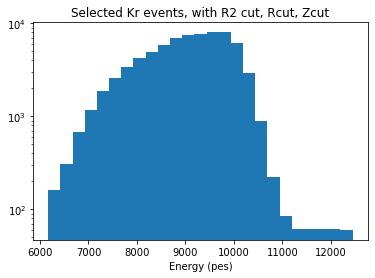

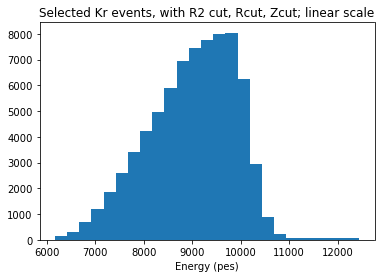

In [16]:
plt.hist(histat_events_energy_subtracted, bins = 25)
plt.yscale('log')
plt.title('Full spectrum')
plt.xlabel('Energy (pes)')
plt.show()

plt.hist(histat_events_energy_subtracted, range=(0, rgt), bins = 25)
plt.yscale('log')
plt.title('Spectrum up to Kr max')
plt.xlabel('Energy (pes)')
plt.show()

plt.hist(histat_events_energy_subtracted[r2mask], range=(0, rgt), bins = 25)
plt.yscale('log')
plt.title('Spectrum up to Kr max, with R2 cut')
plt.xlabel('Energy (pes)')
plt.show()

plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(0, rgt), bins = 25)
plt.yscale('log')
plt.title('Spectrum up to Kr max, with R2 cut, Rcut, Zcut')
plt.xlabel('Energy (pes)')
plt.show()

plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(lft, rgt), bins = 25)
plt.yscale('log')
plt.title('Selected Kr events, with R2 cut, Rcut, Zcut')
plt.xlabel('Energy (pes)')
plt.show()

plt.hist(histat_events_energy_subtracted[histat_selfmask], bins = 25)
plt.title('Selected Kr events, with R2 cut, Rcut, Zcut; linear scale')
plt.xlabel('Energy (pes)')
plt.show()

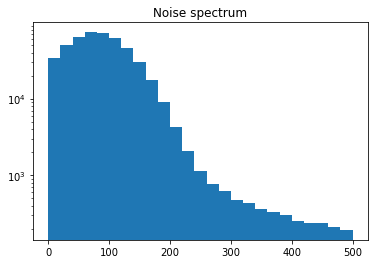

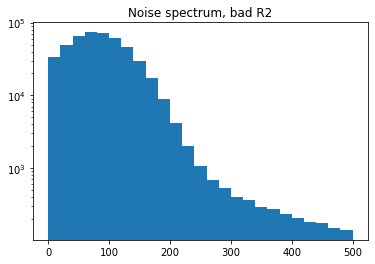

In [17]:
plt.hist(histat_events_energy_subtracted, range=(0, 500), bins = 25)
plt.title('Noise spectrum')
plt.yscale('log')
plt.show()

plt.hist(histat_events_energy_subtracted[~r2mask], range=(0, 500), bins = 25)
plt.title('Noise spectrum, bad R2')
plt.yscale('log')
plt.show()

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


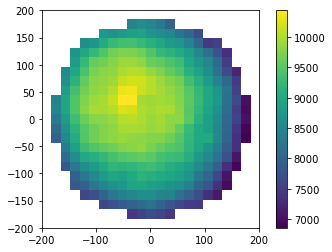

In [18]:
# Create own correction map

nbins = 23
clim = 200
dbin = 2 * clim / nbins
coord_range = np.linspace(-clim, clim, nbins + 1)
coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
events_sum = np.zeros((len(coord_bins),len(coord_bins)))
for ix in range(len(coord_bins)):
    for iy in range(len(coord_bins)):
        xbin = coord_bins[ix]
        ybin = coord_bins[iy]
        xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
        ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
        xymask = xmask & ymask
        events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
        energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted[xymask & histat_selfmask])
        
energy_xy = energy_sum / events_sum
energy_xy_bounds = ((-200, 200), (-200, 200))

plt.imshow(energy_xy, extent=[-200, 200, -200, 200])
plt.colorbar()
plt.show()

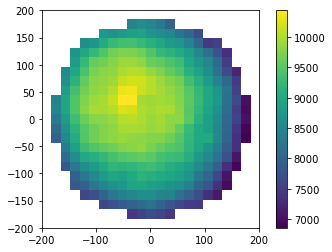

In [19]:
map_out = './maps_from_maxsipm/map_'+runno+'.npy'

with open(map_out, 'wb') as f:
    np.save(f, energy_xy)
    
with open(map_out, 'rb') as f:
    test_readin_xy = np.load(f)

plt.imshow(test_readin_xy, extent=[-200, 200, -200, 200])
plt.colorbar()
plt.show()

Correcting energies...
0 / 583410
10000 / 583410
Est remaining = 25.8
20000 / 583410
Est remaining = 23.9
30000 / 583410
Est remaining = 21.6
40000 / 583410
Est remaining = 21.0
50000 / 583410
Est remaining = 20.9
60000 / 583410
Est remaining = 21.1
70000 / 583410
Est remaining = 20.1
80000 / 583410
Est remaining = 19.5
90000 / 583410
Est remaining = 18.7
100000 / 583410
Est remaining = 18.2
110000 / 583410
Est remaining = 17.9
120000 / 583410
Est remaining = 17.6
130000 / 583410
Est remaining = 17.1
140000 / 583410
Est remaining = 16.7
150000 / 583410
Est remaining = 16.3
160000 / 583410
Est remaining = 15.9
170000 / 583410
Est remaining = 15.8
180000 / 583410
Est remaining = 15.3
190000 / 583410
Est remaining = 14.9
200000 / 583410
Est remaining = 14.5
210000 / 583410
Est remaining = 14.1
220000 / 583410
Est remaining = 13.8
230000 / 583410
Est remaining = 13.4
240000 / 583410
Est remaining = 13.0
250000 / 583410
Est remaining = 12.7
260000 / 583410
Est remaining = 12.3
270000 / 5834

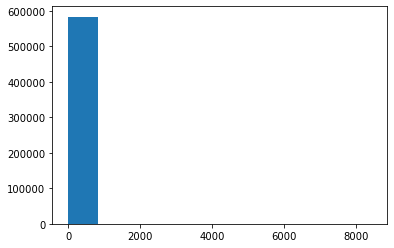

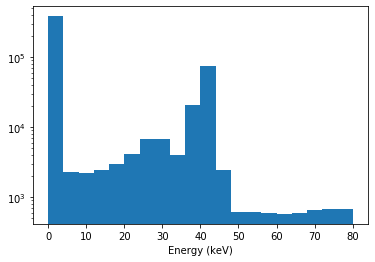

In [20]:
histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)
histat_all_scaled_energy *= 41.5

plt.hist(histat_all_scaled_energy, range = (0, 80), bins = 20)
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

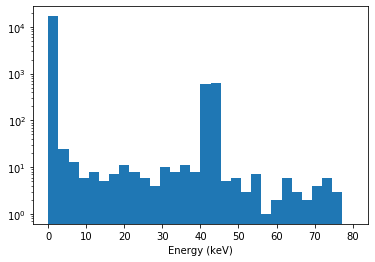

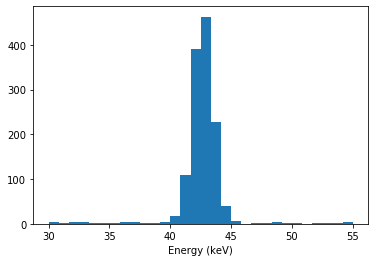

In [21]:
histat_center_mask = (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histat_Zgauss[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

histat_center_mask = (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histat_Zgauss[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
plt.xlabel('Energy (keV)')
plt.show()

Correcting energies...
0 / 74206
10000 / 74206
Est remaining = 3.0
20000 / 74206
Est remaining = 2.4
30000 / 74206
Est remaining = 1.8
40000 / 74206
Est remaining = 1.3
50000 / 74206
Est remaining = 0.9
60000 / 74206
Est remaining = 0.6
70000 / 74206
Est remaining = 0.2


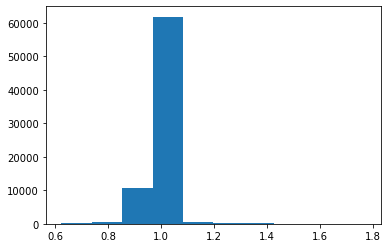

In [22]:
# r7472_scaled_energy = correct_energies(e0_7472, bounds_7472, umask = selfmask, ltmap = lt_7472)
# r7472_res_vs_zr = fit_res_vs_zr(r7472_scaled_energy, e0_7472, bounds_7472, umask = selfmask)
histat_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_selfmask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)

Attempting to fit a Gaussian with guess (A0, m0, s0) = (188.0, 1, 0.03527729867652381)


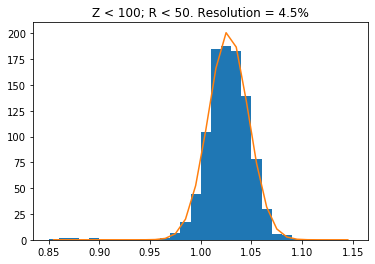

Attempting to fit a Gaussian with guess (A0, m0, s0) = (752.0, 1, 0.03764536834594623)


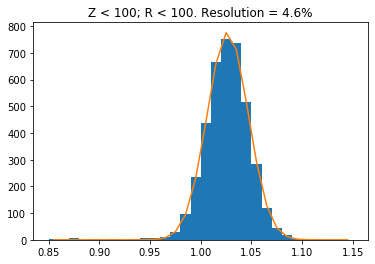

Attempting to fit a Gaussian with guess (A0, m0, s0) = (1614.0, 1, 0.03872744760380014)


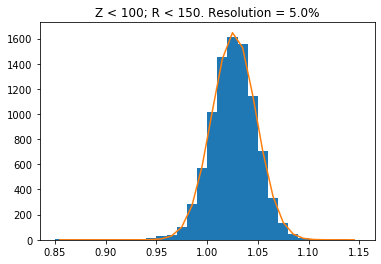

Attempting to fit a Gaussian with guess (A0, m0, s0) = (2164.0, 1, 0.04320327632169378)


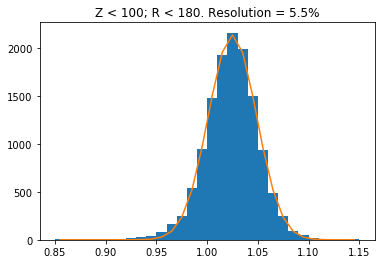

Attempting to fit a Gaussian with guess (A0, m0, s0) = (401.0, 1, 0.041023665665317004)


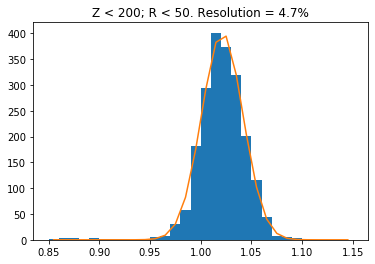

Attempting to fit a Gaussian with guess (A0, m0, s0) = (1531.0, 1, 0.04008429836447771)


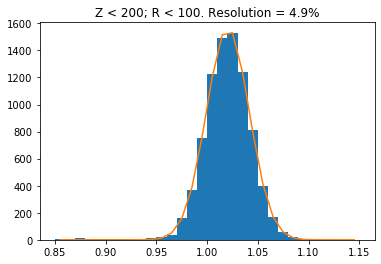

Attempting to fit a Gaussian with guess (A0, m0, s0) = (3336.0, 1, 0.04120618927724085)


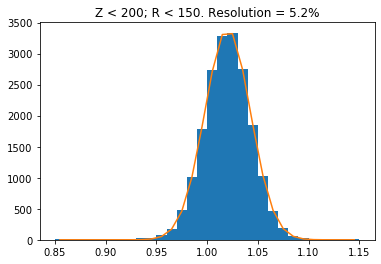

Attempting to fit a Gaussian with guess (A0, m0, s0) = (4409.0, 1, 0.04616000346461617)


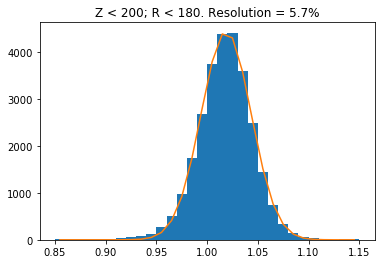

Attempting to fit a Gaussian with guess (A0, m0, s0) = (587.0, 1, 0.0407176372392655)


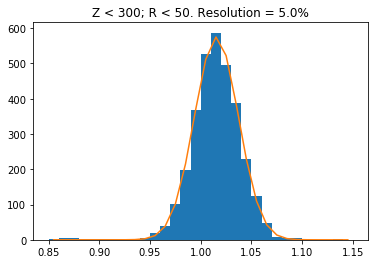

Attempting to fit a Gaussian with guess (A0, m0, s0) = (2200.0, 1, 0.03986513899995856)


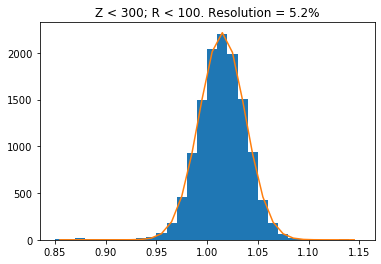

Attempting to fit a Gaussian with guess (A0, m0, s0) = (4884.0, 1, 0.04169333269849451)


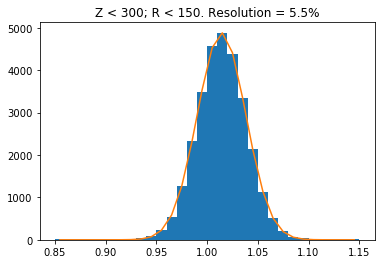

Attempting to fit a Gaussian with guess (A0, m0, s0) = (6418.0, 1, 0.04788077102277369)


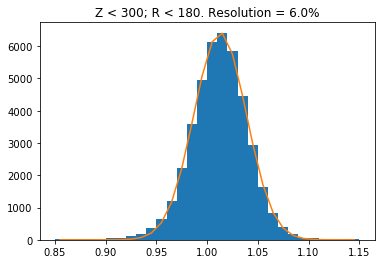

Attempting to fit a Gaussian with guess (A0, m0, s0) = (744.0, 1, 0.04051243336665692)


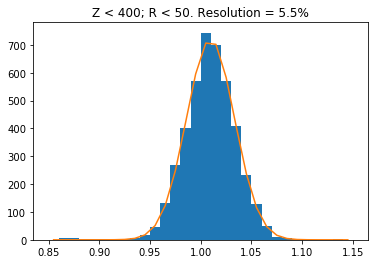

Attempting to fit a Gaussian with guess (A0, m0, s0) = (2767.0, 1, 0.03977657880689992)


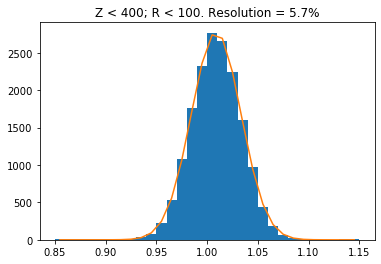

Attempting to fit a Gaussian with guess (A0, m0, s0) = (6083.0, 1, 0.0420037220981511)


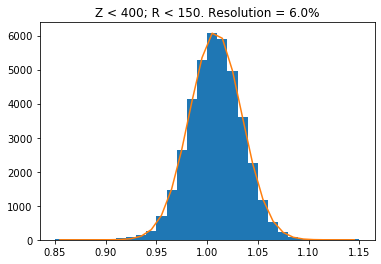

Attempting to fit a Gaussian with guess (A0, m0, s0) = (8117.0, 1, 0.048226168422942556)


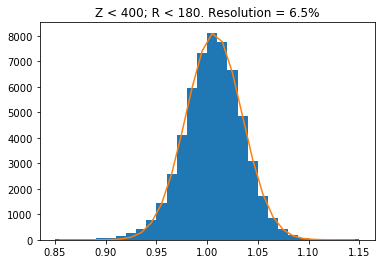

Attempting to fit a Gaussian with guess (A0, m0, s0) = (860.0, 1, 0.03950479987688775)


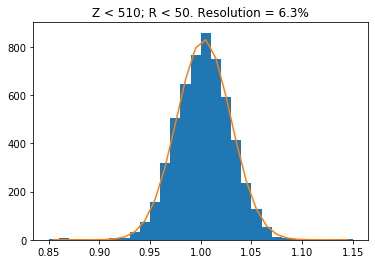

Attempting to fit a Gaussian with guess (A0, m0, s0) = (3217.0, 1, 0.03929086275649639)


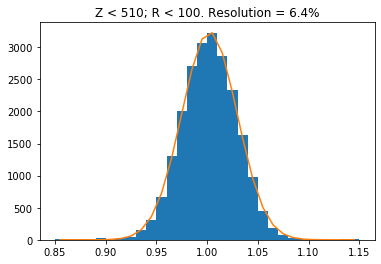

Attempting to fit a Gaussian with guess (A0, m0, s0) = (7068.0, 1, 0.04199024606896495)


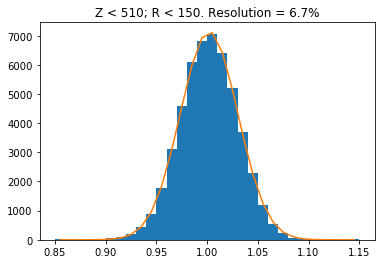

Attempting to fit a Gaussian with guess (A0, m0, s0) = (9410.0, 1, 0.04848462698886276)


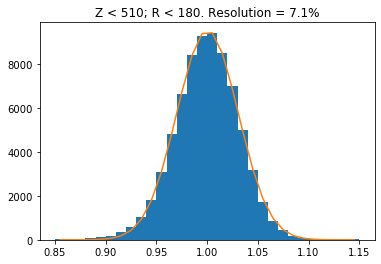

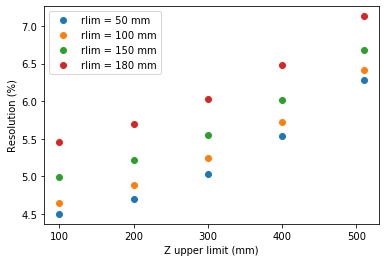

Best resolution =  4.5 %


In [23]:
histat_self_res_vs_zr = fit_res_vs_zr(histat_scaled_energy, energy_xy, energy_xy_bounds, umask = histat_selfmask, xvals = histatX, yvals = histatY, zvals = histat_Zgauss)
plot_res_vs_zr(histat_self_res_vs_zr)